In [2]:
!pip install wordcloud

Clustering 1117452×1000 TF-IDF vectors into k=10
 • scikit-learn        : 14.554s


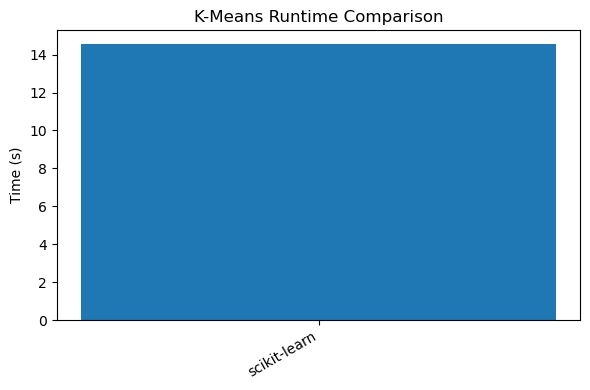

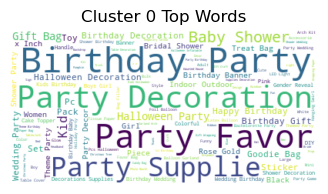

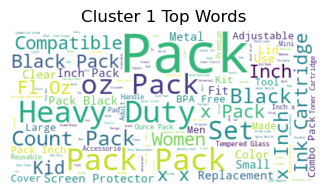

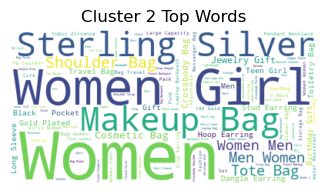

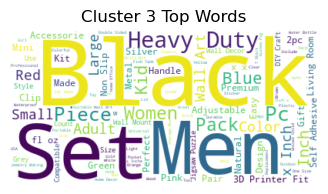

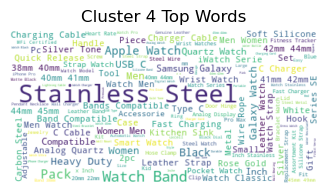

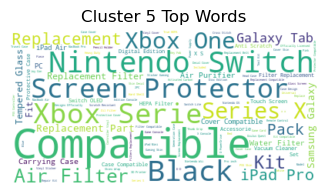

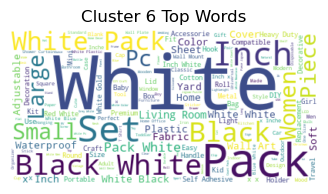

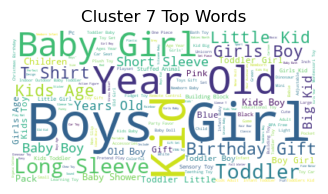

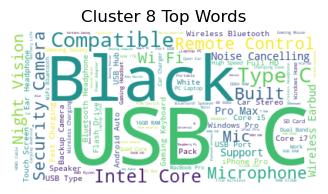

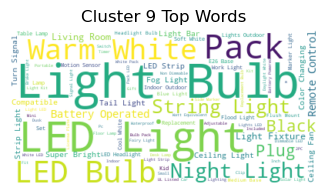

In [7]:
import pandas as pd
import numpy as np
import time
from itertools import product
from numba import njit
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud

# ─── 1) Configuration ────────────────────────────────────────────────────────────
DATA_PATH  = "amazon_products.csv"  # path to your CSV
SAMPLE_N   = 1_117_452                 # how many titles to sample
MAX_FEAT   = 1_000                  # TF-IDF features
MAX_ITERS  = 10
CLUSTERS   = 10

# ─── 2) Load & TF-IDF ─────────────────────────────────────────────────────────────
df = pd.read_csv(DATA_PATH, usecols=["title"]).dropna().drop_duplicates()
titles = df["title"].sample(SAMPLE_N, random_state=0).tolist()


tfidf = TfidfVectorizer(max_features=MAX_FEAT, stop_words="english")
X = tfidf.fit_transform(titles).toarray()  # shape (SAMPLE_N, MAX_FEAT)

# ─── 3) PCA for later (optional) ─────────────────────────────────────────────────
pca2 = PCA(n_components=2, random_state=0)
X2 = pca2.fit_transform(X)

# ─── 4) K-Means with SKLEARN Implementations ──────────────────────────────────────────────────


def kmeans_sklearn(data, k, max_iters=MAX_ITERS):
    """scikit-learn’s KMeans."""
    km = KMeans(n_clusters=k, max_iter=max_iters, n_init=1, random_state=0)
    km.fit(data)
    return km.labels_, km.cluster_centers_


# ─── 5) Benchmark & Bar Chart ────────────────────────────────────────────────────
methods = [
    ("scikit-learn",     kmeans_sklearn),
]

print(f"Clustering {X.shape[0]}×{X.shape[1]} TF-IDF vectors into k={CLUSTERS}")
times = {}
for name, fn in methods:
    start = time.time()
    labels, cents = fn(X, CLUSTERS)
    t = time.time() - start
    times[name] = t
    print(f" • {name:20s}: {t:.3f}s")

# Bar chart
plt.figure(figsize=(6,4))
names = list(times.keys())
vals  = [times[n] for n in names]
plt.bar(names, vals)
plt.ylabel("Time (s)")
plt.title("K-Means Runtime Comparison")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# ─── 6) Word Clouds per Cluster ─────────────────────────────────────────────────
# Use the scikit-learn labels for “ground truth”
sk_labels, _ = kmeans_sklearn(X, CLUSTERS)

for j in range(CLUSTERS):
    texts = [titles[i] for i, lab in enumerate(sk_labels) if lab == j]
    if not texts:
        continue
    wc = WordCloud(width=400, height=200, background_color="white") \
         .generate(" ".join(texts))
    plt.figure(figsize=(4,2))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {j} Top Words")
plt.show()

In [8]:
import random
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

def sample_bigrams(bigrams, m=30):
    """Randomly sample up to m bigrams without replacement."""
    if len(bigrams) <= m:
        return bigrams
    return random.sample(bigrams, m)

def get_all_similar_titles(titles, num_perm=128, threshold=0.5, m_sample=30):
    """
    titles: List of title strings
    num_perm: Number of permutations for MinHash
    threshold: LSH threshold
    m_sample: Number of bigrams to randomly sample for FastLSH
    """

    # Step 1: Create MinHash signatures
    minhashes = {}
    print("Generating MinHash signatures with FastLSH sampling...")
    for idx, title in enumerate(tqdm(titles)):
        bigrams = [title[i:i+2] for i in range(len(title)-1)]
        sampled_bigrams = sample_bigrams(bigrams, m=m_sample)

        m = MinHash(num_perm=num_perm)
        for bg in sampled_bigrams:
            m.update(bg.encode('utf8'))

        minhashes[idx] = m

    # Step 2: Create the LSH index
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    print("Inserting into LSH index...")
    for idx, m in tqdm(minhashes.items()):
        lsh.insert(idx, m)

    # Step 3: Query for similar pairs
    print("Querying similar pairs...")
    similar_pairs = []
    for idx, m in tqdm(minhashes.items()):
        result = lsh.query(m)
        for match_idx in result:
            if idx < match_idx:  # Avoid duplicate pairs
                similar_pairs.append((idx, match_idx))

    return similar_pairs

In [9]:
similar_pairs = get_all_similar_titles(titles, num_perm=128, threshold=0.5, m_sample=30)


Generating MinHash signatures with FastLSH sampling...


100%|██████████| 1117452/1117452 [08:27<00:00, 2202.93it/s]


Inserting into LSH index...


100%|██████████| 1117452/1117452 [00:53<00:00, 20943.99it/s]


Querying similar pairs...


100%|██████████| 1117452/1117452 [00:54<00:00, 20467.11it/s]


In [ ]:
for idx1, idx2 in similar_pairs:
    print(f"{titles[idx1]} ~ {titles[idx2]}")

UEETEK Kitty Cat Scratch Pad,Sisal Hanging Scratch Pad Wall Saver Corner Cat Scratcher Mat,17.3x3.1x1 Inch(Random Color) ~ Mens Linen Casual Pants Elastic Waist Drawstring Trousers Yoga Beach Summer Pants
UEETEK Kitty Cat Scratch Pad,Sisal Hanging Scratch Pad Wall Saver Corner Cat Scratcher Mat,17.3x3.1x1 Inch(Random Color) ~ 60 Degree V Groove Router Bit 1/4 Inch Shank, Carbide Insert Wood CNC Router Bits for Woodworking Engraving Carving
UEETEK Kitty Cat Scratch Pad,Sisal Hanging Scratch Pad Wall Saver Corner Cat Scratcher Mat,17.3x3.1x1 Inch(Random Color) ~ 100 Pieces Moon Star Organza Jewelry Candy Bags, 2.7x3.5 Inch Random Color Organza Pouch Small Gift Bags with Drawstring for Christmas Party Favors Wedding Valentine's Day
UEETEK Kitty Cat Scratch Pad,Sisal Hanging Scratch Pad Wall Saver Corner Cat Scratcher Mat,17.3x3.1x1 Inch(Random Color) ~ Cars 3 Disney Pixar 10-Inch Lightning McQueen Vehicle
UEETEK Kitty Cat Scratch Pad,Sisal Hanging Scratch Pad Wall Saver Corner Cat Scratch

: 